# Trump, Twitter, Russian Bots and the 2016 Election
---

In this project, I work with the Twitter API and look at Trump's tweets, along with a data set of tweets from Russian bot accounts. Note this does *not* include those uncovered and deleted recently by twitter due to the current investigation.

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

## Downloading Recent Tweets


In [2]:
import tweepy
from pathlib import Path
import json

In [3]:
key_file = 'keys.json'
# Loading your keys from keys.json (which you should have filled
# in in question 1):
with open(key_file) as f:
    keys = json.load(f)
# if you print or view the contents of keys be sure to delete the cell!

In [4]:
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error")
    logging.warning(e)

Your username is: Evnwalsh


In [5]:
# Some helper functions to get tweets:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    key_file = path
    with open(key_file) as file:
        auth_keys = json.load(file)
    return auth_keys

In [6]:
def download_recent_tweets_by_user(user_account_name, key_file):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Dictonary objects, each representing one tweet."""
    
    tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, tweet_mode='extended').items()]
    return tweets
    
    """ IGNORE BELOW SAVING IN CASE NEED TO EDIT!
    save_path = user_account_name + "_latest_tweets.json"
    # Guard against many attempts to download data and overload requests
    if not Path(save_path).is_file():
        tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, tweet_mode='extended').items()]
        with open(save_path, "w") as f:
            json.dump(tweets, f)
    with open(save_path) as f:
        tweets = json.load(f)
    return tweets"""

In [7]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Dictionary) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    with open(path, "w") as f:
        json.dump(tweets, f)

In [8]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    with open(path) as f:
        tweets = json.load(f)
    return tweets

In [9]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    save_path = user_account_name + "_recent_tweets.json"
    if not Path(save_path).is_file():
        tweets = download_recent_tweets_by_user(user_account_name, keys_path)
        save_tweets(tweets, save_path)
    return load_tweets(save_path)

In [10]:
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 3223


In [12]:
# We notice that there are only 3000 some tweets, which is not enough!
# So we merge it with a file that has more trump tweets

In [27]:
# As you may have seen, we have a file of older trump tweets, so 
# we just merge that:

with open('old_trump_tweets.json') as json_data:
    old_trump_tweets = json.load(json_data)

# create list of ids in trump_tweets
ids = []
for x in trump_tweets:
    if x.get('id') not in ids:
        ids.append(x.get('id'))

# set tweet_lst to all trump tweets (because these IDs are unique)
# make sure to not modify trump_tweets below!
tweet_lst = trump_tweets[:]

# Now add all old_trump_tweets who's ids are NOT in id tracker.
for y in old_trump_tweets:
    if y.get('id') not in ids:
        ids.append(y.get('ds'))
        tweet_lst.append(y)
        
# Here we are:
all_tweets = tweet_lst

In [28]:
# This length looks a little better:
len(all_tweets)

6901

Now let's create a dataframe and begin doing some cleaing and exploration

In [46]:
trump = pd.DataFrame({
    'time': pd.to_datetime([tweet['created_at'] for tweet in all_tweets]),
    'source': [tweet['source'] for tweet in all_tweets],
    'text': [tweet['text'] if "text" in tweet else tweet['full_text'] for tweet in all_tweets],
    'retweet_count': [tweet["retweet_count"] for tweet in all_tweets],
}, index=[tweet['id'] for tweet in all_tweets],
   columns=['time', 'source', 'text', 'retweet_count'],
).sort_index()
trump.head()


,time,source,text,retweet_count
690171032150237184,2016-01-21 13:56:11,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059
690171403388104704,2016-01-21 13:57:39,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339
690173226341691392,2016-01-21 14:04:54,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006
690176882055114758,2016-01-21 14:19:26,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266
690180284189310976,2016-01-21 14:32:57,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886


## Tweet Source Analysis

Let's look at the characteristics of the devices that Trump made these tweets on.

We first need to remove HTLM tags

In [47]:
# Get rid of first <, then get rid of >
reformated_source = trump['source'].str.replace('<[^>]+>', '')

trump['source'] = reformated_source

Let's use a bar plot to see what was used most

Text(0,0.5,'Number of Tweets')

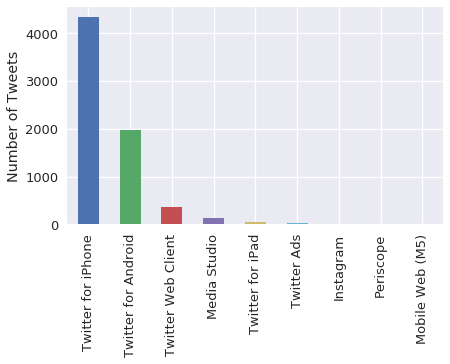

In [48]:
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")

Interesting, but we should break this down more and see if there are any interesting behavior patterns

In [49]:
# Convert tweets to East Coast Time:
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,est_time
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059,2016-01-21 08:56:11-05:00
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339,2016-01-21 08:57:39-05:00
690173226341691392,2016-01-21 14:04:54,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006,2016-01-21 09:04:54-05:00
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266,2016-01-21 09:19:26-05:00
690180284189310976,2016-01-21 14:32:57,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886,2016-01-21 09:32:57-05:00


In [50]:
# Now add a column called hour
hour = []
for x in trump['est_time']:
    x = x.hour + (x.minute / 60) + x.second / (60 * 60)
    hour.append(x)
    
trump['hour'] = hour


Now we use a distplot to examine how tweets are distributed over the hours. 

In [51]:
iphone_tweets = trump[trump['source'] == 'Twitter for iPhone']
android_tweets = trump[trump['source'] == 'Twitter for Android']

Text(0.5,1,'Time of use by device')

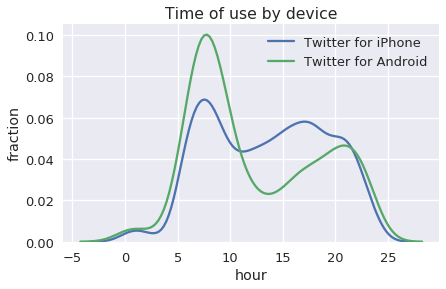

In [52]:
phoneplt = sns.distplot(iphone_tweets['hour'], hist=False, label='Twitter for iPhone')
phoneplt = sns.distplot(android_tweets['hour'], hist=False, label='Twitter for Android')
phoneplt.set(ylabel='fraction')
plt.title('Time of use by device')


We can see some striking diffefrences in the curve. As we have all become to diplomatic twitter broadsides around 3am PST, Trump tends to tweet (himself--not staff) in the late evening and early morning. These tweets seem to come more from his Android device. This may mean he uses it as a personal device (as it is in his personal bedroom away from aides, etc.). During work, it seems he uses an iPhone. Perhaps the US government favors this for security. When it gets late in the day, Trump tweets less--going to bed (or maybe his audience is asleep so he does not use twitter!).

But, we may have all heard that Trump recently moved to an iPhone. Let's examine this distribution as the year goes on. 

In [55]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length


trump['year'] = trump['time'].apply(year_fraction)

Now, again using a seaborne distplot, we can overlay the distributions of the 2 most frequently used web technologies over the year.

Text(0.5,1,'Distribution of most used devices over years')

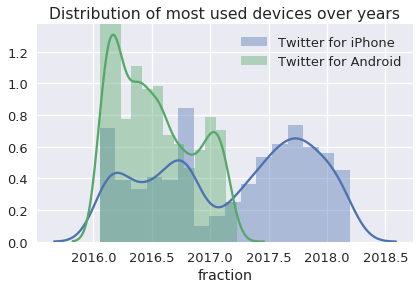

In [56]:
iphone_tweets = trump[trump['source'] == 'Twitter for iPhone']
android_tweets = trump[trump['source'] == 'Twitter for Android']

sns.distplot(iphone_tweets['year'], label = 'Twitter for iPhone')
sns.distplot(android_tweets['year'], label = 'Twitter for Android')
plt.legend()
plt.xlabel('fraction')
plt.title('Distribution of most used devices over years')

According to the plot, Trump's tweets come from many different sources. It turns out that many of his tweets were not from Trump himself but from his staff. [Take a look at this Verge article.](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android)

Our data certainly does support the rumor that Trump is now using a more secure iPhone. We see that right at the start of 2017 (his inauguration), all tweets started coming from an iPhone while none from his Android device. This is exaclty what was described in the article. Also, most of his tweets from Android are likely from him, as they are more entertaining! His staff likely used the iPhone prior to January 2017.

## Tweet Sentiment Analysis

Trump's tweets are well-known for their wide ranging emotions. It turns out we can measure how he's feeling based on a tweet. We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. The VADER lexicon gives the sentiment of individual words.

In [61]:
# Here's a preview of the tool:
print(''.join(open("vader_lexicon.txt").readlines()[100:110]))

:')	2.3	0.78102	[3, 1, 3, 2, 2, 2, 2, 4, 2, 2]
:'-(	-2.4	0.66332	[-2, -1, -2, -3, -2, -3, -3, -3, -2, -3]
:'-)	2.7	0.64031	[2, 1, 3, 3, 3, 3, 3, 3, 3, 3]
:(	-1.9	1.13578	[-2, -3, -2, 0, -1, -1, -2, -3, -1, -4]
:)	2.0	1.18322	[2, 2, 1, 1, 1, 1, 4, 3, 4, 1]
:*	2.5	1.0247	[3, 2, 1, 1, 2, 3, 4, 3, 4, 2]
:-###..	-2.5	0.92195	[-3, -2, -3, -2, -4, -3, -1, -3, -1, -3]
:-&	-0.5	0.92195	[-1, -1, 0, -1, -1, -1, -1, 0, 2, -1]
:-(	-1.5	0.5	[-2, -1, -1, -1, -2, -2, -2, -1, -2, -1]
:-)	1.3	0.45826	[1, 1, 1, 1, 2, 1, 2, 1, 2, 1]



In [63]:
# Now read it into a data frame so we can do useful stuff with it!
vader = pd.read_table('vader_lexicon.txt', names = ['token', 'polarity', 'sd', 'sentiment' ])
vader.drop(['sd', 'sentiment'], axis = 1, inplace=True)
vader.set_index('token', inplace=True)
sent = vader


let's use this lexicon to calculate the overall sentiment for each of Trump's tweets:


In [64]:
# set to lower case and replace \n with space (line breaks)
trump['text'] = trump['text'].str.lower()
trump['text'] = trump['text'].str.replace('\n', ' ')

In [65]:
# Now get rid of punctuation by creating no_punc col in df
punct_re = '[^A-Za-z0-9_\\s]'
trump['no_punc'] = trump['text'].str.replace(punct_re, ' ')
trump['no_punc']

690171032150237184                                                                                                                                                                                                                          bigop1   realdonaldtrump   sarahpalinusa https   t co 3kyqgqevyd 
690171403388104704                                                                                                                                                            americanaspie    glennbeck  sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border  me too  
690173226341691392                                                                                                                                                                so sad that  cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma  dishonest reporting 
690176882055114758                                                                            

Now convert into a tidy format to make sentiment easier to calculate. We'll use the no_punc column to create a table called tidy_format.

The index of the table has the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.


In [68]:
tidy_format = (
    trump['no_punc']
    .str.split(expand=True)
    .stack()
    .reset_index(level=1)
    .rename(columns={'level_1': 'num', 0: 'word'})
)
tidy_format.head()


,num,word
690171032150237184,0,bigop1
690171032150237184,1,realdonaldtrump
690171032150237184,2,sarahpalinusa
690171032150237184,3,https
690171032150237184,4,t


Now that we have formated text, we can now find the sentiment of eaech tweet after we join it with the lexicon table. We will add polarity, the sentiment of each word, to the data frame

In [70]:
trump['polarity'] = (
    tidy_format
    .merge(sent, how='left', left_on='word', right_index=True)
    .reset_index()
    .loc[:, ['index', 'polarity']]
    .groupby('index')
    .sum()
    .fillna(0)
)
trump[['text', 'polarity']].head()

,text,polarity
690171032150237184,"""@bigop1: @realdonaldtrump @sarahpalinusa https://t.co/3kyqgqevyd""",0.0
690171403388104704,"""@americanaspie: @glennbeck @sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border? me too!""",-2.6
690173226341691392,so sad that @cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma. dishonest reporting!,-6.0
690176882055114758,"sad sack @jebbush has just done another ad on me, with special interest money, saying i won't beat hillary - i will. but he can't beat me.",4.3
690180284189310976,low energy candidate @jebbush has wasted $80 million on his failed presidential campaign. millions spent on me. he should go home and relax!,-2.6


Cool! It's done. Now we can see some interesting tweets:

In [71]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   thank you to linda bean of l.l.bean for your great support and courage. people will support you even more now. buy l.l.bean. @lbperfectmaine

   it was my great honor to celebrate the opening of two extraordinary museums-the mississippi state history museum &amp; the mississippi civil rights museum. we pay solemn tribute to our heroes of the past &amp; dedicate ourselves to building a future of freedom, equality, justice &amp; peace. https://t.co/5akgvpv8aa

   rt @ivankatrump: 2016 has been one of the most eventful and exciting years of my life. i wish you peace, joy, love and laughter. happy new…

   today, it was my great honor to sign a new executive order to ensure veterans have the resources they need as they transition back to civilian life. we must ensure that our heroes are given the care and support they so richly deserve! https://t.co/0mdp9ddias https://t.co/lp2a8kcbap

   it was my great honor to welcome mayor’s from across america to the wh. my ad

In [72]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   horrible and cowardly terrorist attack on innocent and defenseless worshipers in egypt. the world cannot tolerate terrorism, we must defeat them militarily and discredit the extremist ideology that forms the basis of their existence!

   democrat jon ossoff would be a disaster in congress. very weak on crime and illegal immigration, bad for jobs and wants higher taxes. say no

   "@fiiibuster: @jeffzeleny pathetic - you have no sufficient evidence that donald trump did not suffer from voter fraud, shame! bad reporter.

   nyc terrorist was happy as he asked to hang isis flag in his hospital room. he killed 8 people, badly injured 12. should get death penalty!

   yet another terrorist attack today in israel -- a father, shot at by a palestinian terrorist, was killed while: https://t.co/cv1hzkvbit


## Fox vs the New York Times
This lexicon analysis has *many* applications. One interesting one is seeing potential bias towards different media sources!

words with nyt in them:
['nytimes' 'anything' '2yyy6nyta9' 'nytdavidbrooks' 'jbnytk3fye' 'nyt'
 'nytimesdowd' 'anytime' 'ifdanyt' 'endakennytd']
words with fox in them:
['fox' 'foxbusiness' 'foxnews' 'fox2' 'foxandfriends' 'aattabfoxx'
 'jojo2foxy' 'foxnewspolitics' 'dumpfoxnews' 'foxnewssunday'
 'johnrobertsfox' 'foxbizalert' 'foxnation' 'hre7foxqpo' 'foxfriendsfirst'
 'foxconn' 'klwn05ufox' 'foxandfrlends']


Text(0,0.5,'fraction')

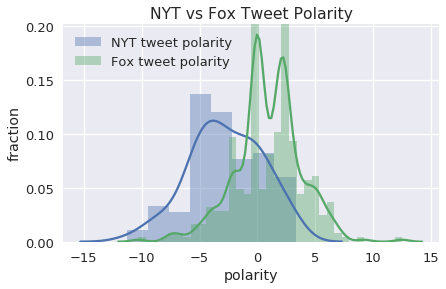

In [73]:
# Let's process NYT mentions first
nyt_tweets = tidy_format[(tidy_format['word'].str.contains('nyt'))]

# Check what values are in nyt_tweets
print('words with nyt in them:')
print(nyt_tweets.word.unique())

# We notice that 'anything', 'endakennytd', 'ifdanyt', 'anytime' 'jbnytk3fye' and '2yyy6nyta9' 
# are not related, so remove them:
nyt_tweets = tidy_format[(tidy_format['word'] == 'nyt') |
                        (tidy_format['word'].str.contains('nytimes')) |
                        (tidy_format['word'].str.contains('nytimesdowd')) |
                        tidy_format['word'].str.contains('nytdavidbrooks')
                        ]


# Now let's process Fox-related tweets:
fox_tweets = tidy_format[(tidy_format['word'].str.contains('fox'))]

# Check what these values actually are:
print('words with fox in them:')
print(fox_tweets.word.unique())

# We see the print line and thus filter out unrelated fox tweets:
fox_tweets = fox_tweets[(fox_tweets['word'] == 'foxnews') |
                       (fox_tweets['word'] == 'foxandfriends') |
                       (fox_tweets['word'] == 'foxbusiness') |
                       (fox_tweets['word'] == 'foxandfrlends') |
                       (fox_tweets['word'] == 'fox') |
                        (fox_tweets['word'] == 'foxfriendsfirst') |
                        (fox_tweets['word'] == 'foxnewssunday') |
                        (fox_tweets['word'] == 'foxnation') |
                        (fox_tweets['word'] == 'foxbizalert') |
                        (fox_tweets['word'] == 'johnrobertsfox') |
                        (fox_tweets['word'] == 'dumpfoxnews') |
                        (fox_tweets['word'] == 'foxnewspolitics')
                       ]

# Merge each with trump table to get total polarity of tweet
nyt_pol = nyt_tweets.merge(trump, right_index=True, left_index=True)['polarity']
fox_pol = fox_tweets.merge(trump, right_index=True, left_index=True)['polarity']

# Graph this:
sns.distplot(nyt_pol, label = 'NYT tweet polarity')
sns.distplot(fox_pol, label = 'Fox tweet polarity')
plt.legend()
plt.title('NYT vs Fox Tweet Polarity')
plt.ylabel('fraction')

So what do we observe?

Based on our results, we see that Trump tends to talk more positively about Fox News. Though there are some negative tweets, we see the distribution (bimodal in shape) has an average polarity somewhere around +2.5, with relatively similar tails in both positive and negative direction. 

On the other hand, the NYT gets more negative tweets directed at it. This distribution seems to have an average of around -4 and is somewhat Guassian with a slight bump at 0. Its tails are relatively similar, though we can see that there are no tweets with polarity greater than +2.5. On the other hand, there are some really negative tweets less than -10 polarity! 

Thus, comparing the two, we get the picture that Trump may favor Fox news (or he at least has a more positive sentiment when tweeting about it). But, as is always the case in Data Science, there are still some things that need to be controlled. Take this tweet as an example (ID = 831830548565852160)

>"the fake news media is going crazy with their conspiracy theories and blind hatred. @msnbc &amp; @cnn are unwatchable. @foxandfriends is great!"

Or this one:

>"rt @foxandfriends: president trump vows america will respond to north korean threats with "fire &amp; fury" in a warning to the rogue nation"

These are the #2 and #3 lowest rated polarity tweets that mention fox (#1 is about Megyn Kelly... yikes). As we can see, the polarity measure only lets us analyze the *overall* sentiment of the tweet--and not necesarily the president's sentiment towards each news outlet. So, in fact, Trump may have an even more positive perception of Fox than this data may lead us to believe!

This makes sense, and thus must be a caveat when considering this data: polarity does **not** control for context! In the end, despite our best efforts, it is really hard to understand how the context plays a roll in overall sentiment. Only a human brain (or really good ML program) can get a good grasp of this collection of tweets!

## Engagement and Sentiment

Which of Trump's tweets had the most retweets? Were there certain words that often led to more retweets?

We can find this out by using our `tidy_format` DataFrame. For each word in the `tidy_format` DF, we find the number of retweets that its tweet got. We'll filter out words that didn't appear in at least 25 tweets, and then find out the median number of retweets each word got.

In [77]:
rt_frame = trump['retweet_count'].to_frame()
rt_frame = rt_frame.merge(tidy_format, left_index=True, right_index=True)
word_counts = rt_frame.groupby('word').count()
word_counts = word_counts[word_counts['num'] >= 25]

In [79]:
# Narrow down trump df to get retweets
rt_frame = trump['retweet_count'].to_frame()

# Merge with tidy_frame so we can get retweets by tweet (and word)
rt_frame = rt_frame.merge(tidy_format, left_index=True, right_index=True)

# Groupby word so we can narrow down to words used more than 25 times
word_counts = rt_frame.groupby('word').count()
word_counts = word_counts[word_counts['num'] >= 25]

# Merge rt_frame with word_counts, get median and then sort counts so we can see
# Which words get the most retweets
top_20 = rt_frame.merge(word_counts, left_on='word', right_index=True).groupby('word').median().sort_values(by = 'retweet_count_x', ascending=False)
top_20 = top_20['retweet_count_x'].to_frame()
top_20 = top_20.rename(columns= {'retweet_count_x' : 'retweet_count'})
top_20 = top_20.head(20)

In [80]:
top_20 

,retweet_count
word,
lowest,29985.0
investigation,28481.5
nfl,24521.0
daca,24047.5
flag,23857.0
fbi,23698.5
russia,23424.0
finally,23051.5
fake,23043.5


Very interesting! But also, is this that surprising? Controversial topics seem to be great for RTs!

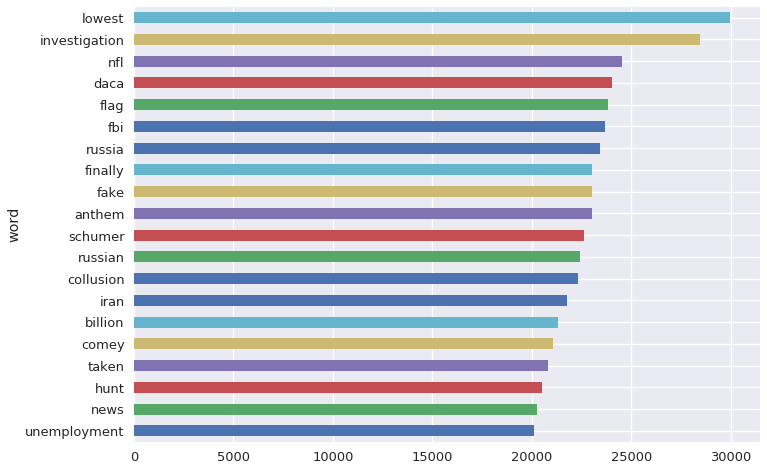

In [81]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));

## Russian Bot Tweet Analysis

First off, Twitter makes it **really** hard to do much in terms of tracking users who follow(ed) Trump. It's not easy to find who retweeted/favorited his tweets and who followed him (past 100 users). I tried this to no avail. Furthermore, we cannot see snapshots of this in time. This is key because recently Twitter deleted *thousands and thousands* of bot accounts related to the Internet Research Agency! Once deleted, we cannot access any information about these accounts. I tried to find cached versions, which were of no help (that I could find in limited time). It does make sense why Twitter would not want us seeing this, though. 

But, there is data from Russian-run Twitter accounts, found here:
https://www.nbcnews.com/tech/social-media/now-available-more-200-000-deleted-russian-troll-tweets-n844731

The crazy part is these are only about 3000 some accounts! In total, they produced over 200k tweets over the span of a year (2016)! So, below I analyze them and bring it back to our Trump tweet and polarity analysis. 

In [83]:
# Read bot user list and bot tweet list as found in folder (predownloaded)
bot_users = pd.read_csv('bot_users.csv')
bot_tweets = pd.read_csv('bot_tweets.csv')

### Let's first see when these tweets happened and if they coincided with events of interest:

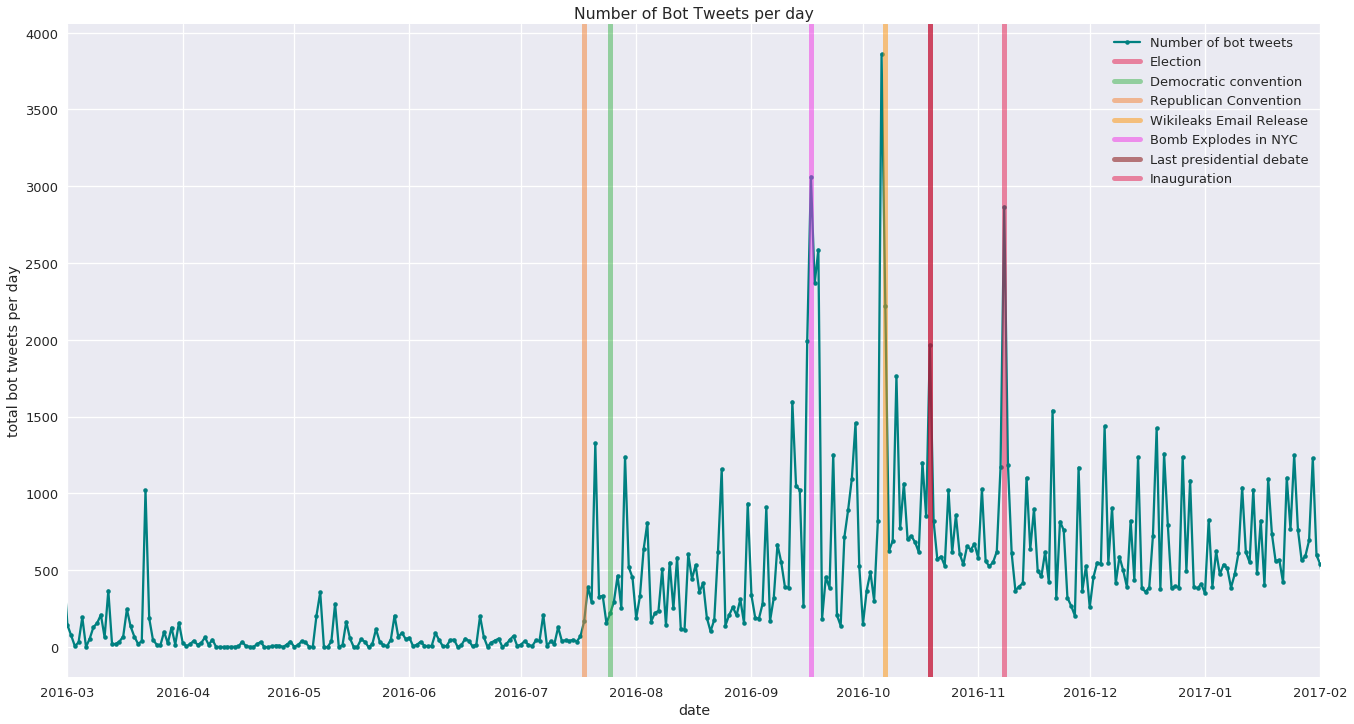

In [84]:
# Reformat dates
reformat_dates = pd.to_datetime(bot_tweets['created_str'])
bot_tweets['date'] = reformat_dates

# Get counts
counts = bot_tweets.set_index('date').groupby(pd.Grouper(freq='D')).count()['user_key']

# Plot graph
fig, ax = plt.subplots(figsize=(20, 12))
sns.set_style("darkgrid")
plt.ylabel('total bot tweets per day')
plt.xlabel('date')
plt.title('Number of Bot Tweets per day')
plt.plot(counts.index, counts, color='teal', label='Number of bot tweets', marker='.')
xmin = datetime.datetime(2016, 3, 1)
xmax = datetime.datetime(2017, 2, 1)
plt.xlim(left=xmin, right=xmax)

# Key dates that correspond to large tweet numbers
election_date = datetime.datetime(2016, 11, 8)
democratic_convention = datetime.datetime(2016, 7, 25)
republican_convention = datetime.datetime(2016, 7, 18)
wikileaks = datetime.datetime(2016, 10, 7)
nyc_bomb = datetime.datetime(2016, 9, 17)
clinton_faints = datetime.datetime(2016, 9, 11)
last_debate = datetime.datetime(2016, 10, 19)
inaug = datetime.datetime(2017, 1, 20)


# Plot key date lines
plt.axvline(x=election_date, color='#e6194b', label = 'Election', alpha=0.5,linewidth=5)
plt.axvline(x=democratic_convention, color='#3cb44b', label = 'Democratic convention', alpha=0.5, linewidth=5)
plt.axvline(x=republican_convention, color='#f58231', label = 'Republican Convention', alpha=0.5, linewidth=5)
plt.axvline(x=wikileaks, color='#ff9408', label = 'Wikileaks Email Release', alpha=0.5, linewidth=5)
plt.axvline(x=nyc_bomb, color='#f032e6', label = 'Bomb Explodes in NYC', alpha=0.5, linewidth=5)
plt.axvline(x=last_debate, color='#800000', label = 'Last presidential debate', alpha=0.5, linewidth=5)
plt.axvline(x=last_debate, color='#e6194b', label = 'Inauguration', alpha=0.5, linewidth=5)

plt.legend()

...Nice... and mildly worrying...

A few interesting things here:

1. The number of tweets put out by the accounts began to increase almost immediately following Trump accepting the RNC nomination. From there on, the average per day increased dramatically. 

2. The days with the most tweets tended to coincide with key events that occured on the campaign trail.

3. Tweets begin to drop off following the election

4. The wikileaks email release coinciding with the highest daily count of bot tweets is interesting. Of course, this is expected as it was a big news story. However, it is rumored that Russia supplied wikileaks with these emails. It could have been a coordinated effort, though more analysis needs to be done to make this assertion.

There's a good chance lots of these Tweets relate to the election. After all, Mueller did just release a bunch of charges aimed at the company that ran these bots. Good enough for me! But, of course, there are lots of things we'd need to control for in order to have an accurate analysis (e.g. does this show a concerted effort? Or are these spikes/sentiments just a reflection of how the greater twitter universe felt?). But, anyways, it's still cool to see all this data!

In [85]:
# How many times did they mention Trump?:
bot_tweets['text'] = bot_tweets['text'].fillna('0')
bot_tweets['mentions'] = bot_tweets['mentions'].str.strip('[]')
trump_mentions = bot_tweets[bot_tweets['mentions'].str.contains('realdonaldtrump')]
mentioncount = trump_mentions['mentions'].count()
print('Number of times Trump is mentioned:')
print(mentioncount)
# trump_mentions

Number of times Trump is mentioned:
3276


### First, lets see how the bots interacted with Trump's account. What did they retweet?

In [93]:
# How many times did bots retweet Trump tweets?
# Notice our data isn't so hot--tweet ID is not always included w/ retweets
# Thus mentions don't suffice and more looking into the data is needed
trump_rts = bot_tweets[bot_tweets['text'].str.contains('RT @realDonaldTrump')]

In [94]:
# Lets merge trump and trump rts to see what was retweeted
trump_rts['retweeted_status_id'] = trump_rts['retweeted_status_id'].fillna(0)
bots_rts = trump.merge(trump_rts, left_index=True, right_on = 'retweeted_status_id')
# Oops yes I know this is bad! Bugfix incoming

/home/evan/anaconda3/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'Polarity of Trump Bot Retweets')

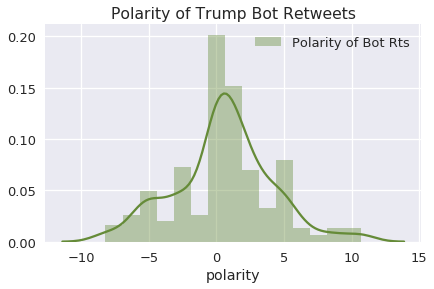

In [95]:
# What was the polarity of the Tweets they retreated?
# I follow steps as above, modified slightly
polarity_bot_rts = bots_rts['polarity']
sns.distplot(polarity_bot_rts, label = 'Polarity of Bot Rts', color='#658b38')
plt.legend()
plt.title('Polarity of Trump Bot Retweets')

In [96]:
bots_rts['polarity'].mean()

0.54208333333333347

Thoughts: graph seems to be a normal distribution. Not super interesting, but nonetheless cool. There may be more  going on here, still.

Here's something interesting about their behavior: They
never once interacted directly with other users (e.g. replying)--just retweets or mentions

In [97]:
# Here's something interesting about their behavior: They
# never once interacted directly with other users (e.g. replying)--just retweets or mentions
bot_tweets['in_reply_to_status_id'] = bot_tweets['in_reply_to_status_id'].fillna(False)
bot_tweets[bot_tweets['in_reply_to_status_id'] == True].count()['in_reply_to_status_id']

0

In [98]:
bot_tweets['new_tweetid'] = range(1,len(bot_tweets)+1)


In [99]:
Well, we used Vader analysis on Trump... so why not these bots??

Object `bots` not found.


## Bot VADER Sentiment Analysis 
Well, we used Vader analysis on Trump... so why not these bots

In [100]:
# Try Vader analysis on bot tweets
bot_tweets['text'] = bot_tweets['text'].str.lower()
bot_tweets['text'] = bot_tweets['text'].str.replace('\n', ' ')
bot_tweets['no_punc'] = bot_tweets['text'].str.replace(punct_re, ' ')

cleaned_format = pd.DataFrame(bot_tweets['no_punc'].str.split("\\s+", expand=True).stack())
cleaned_format.reset_index(inplace=True)
cleaned_format = cleaned_format.rename(columns={'level_1' : 'num', 0 : 'word'})
cleaned_format.set_index('level_0', inplace=True)
cleaned_format = cleaned_format.rename(index={'tweetid':'tweetid'})


In [101]:
# Merge with sent
tot_pol = cleaned_format.merge(sent, how='inner', left_on = 'word', right_index=True)['polarity'].fillna(0).groupby('level_0').sum()
bot_tweets['polarity'] = tot_pol
bot_tweets.fillna(0, inplace=True)

In [105]:
# Print most negative tweets:
print("I COMMENTED THIS OUT BECAUSE IT HAS ~~VERY~~ OFFENSIVE TERMS")
print("UNCOMMENT AND RUN AT OWN PERIL!")


# print('Most negative tweets:')
# for t in bot_tweets.sort_values('polarity').head(10)['text']:
#    print('\n  ', t)

I COMMENTED THIS OUT BECAUSE IT HAS ~~VERY~~ OFFENSIVE TERMS
UNCOMMENT AND RUN AT OWN PERIL!


In [106]:
print('Most positive tweets:')
for t in bot_tweets.sort_values('polarity', ascending=False).head(10)['text']:
    print('\n  ', t)


Most positive tweets:

   rt @instapundit: ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha!!! https://t.co/irf2kbhvaz

 love &amp; happiness 2 all 💙 htt…

   love love love love love love loveee

   rt @diamondandsilk: happy anniversary to @laraleatrump and @erictrump.  hope your day is full of love, peace, joy &amp; happiness.  we love you…

 #m…

   rt @randycaputo: ha ha ha ha ha worked her way. ha ha ha ha ask @berniesanders  ha ha ha ha https://t.co/mwxxft5gkk

 https://t.c…

   so much love, passion, patriotism, excitement, joy, pride, anticipation and love♥️! beautiful rally!🇺🇸

   rt @lindaleeking: just got out and yes so many wonderful warm hugs and kisses to the winners congratulations to all this was a wonderfully…

   rt @ivankatrump: 2016 has been one of the most eventful and exciting years of my life. i wish you peace, joy, love and laughter. happy new…


### Breakdown of sentiment based on topic
Now this is pretty cool, since these bots seemed to influence public discourse on social media. So what did they think about clinton? Islam? Obama? There's lots to be done!

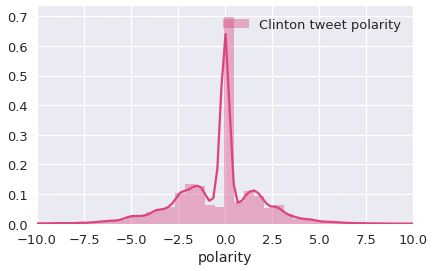

In [107]:
clinton_tweets = cleaned_format[(cleaned_format['word'].str.contains('clinton'))]
clinton_pol = clinton_tweets.merge(bot_tweets, right_index=True, left_index=True)
sns.distplot(clinton_pol['polarity'], label = 'Clinton tweet polarity', color='#da467d')
plt.xlim([-10, 10])
plt.legend()

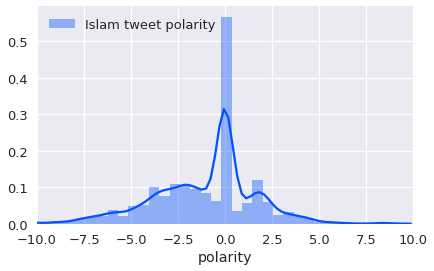

In [108]:
islam_tweets = cleaned_format[(cleaned_format['word'].str.contains('islam'))]
islam_pol = islam_tweets.merge(bot_tweets, right_index=True, left_index=True)['polarity']
sns.distplot(islam_pol, label = 'Islam tweet polarity', color='#0652ff')
plt.xlim([-10, 10])
plt.legend()
# islam_pol.mean()

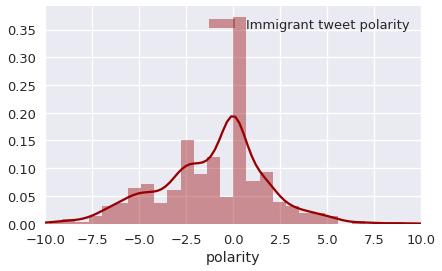

In [109]:
immigrant_tweets = cleaned_format[(cleaned_format['word'].str.contains('immigrant'))]
immigrant_pol = immigrant_tweets.merge(bot_tweets, right_index=True, left_index=True)['polarity']
sns.distplot(immigrant_pol, label = 'Immigrant tweet polarity', color='#980002')
plt.xlim([-10, 10])
plt.legend()
# immigrant_pol.mean()

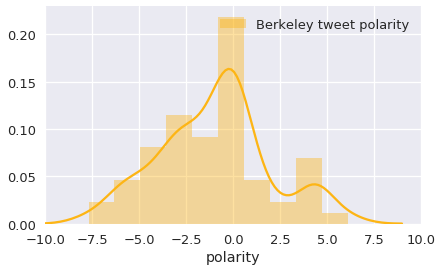

In [110]:
berkeley_tweets = cleaned_format[(cleaned_format['word'].str.contains('berkeley'))]
berkeley_pol = berkeley_tweets.merge(bot_tweets, right_index=True, left_index=True)['polarity']
sns.distplot(berkeley_pol, label = 'Berkeley tweet polarity', color='#FDB515')
plt.xlim([-10, 10])
plt.legend()

****GO BEARS! ****

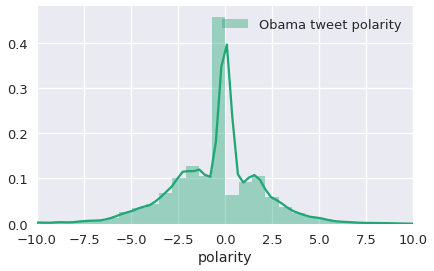

In [111]:
obama_tweets = cleaned_format[(cleaned_format['word'].str.contains('obama'))]
obama_pol = obama_tweets.merge(bot_tweets, right_index=True, left_index=True)['polarity']
sns.distplot(obama_pol, label = 'Obama tweet polarity', color='#1fa774')
plt.xlim([-10, 10])
plt.legend()

Thanks Obama!

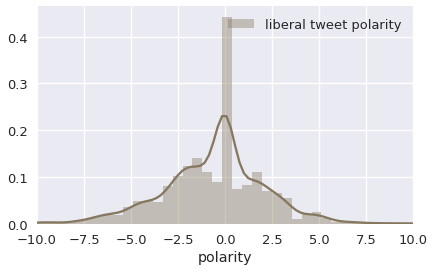

In [112]:
liberal_tweets = cleaned_format[(cleaned_format['word'].str.contains('liberal'))]
liberal_pol = liberal_tweets.merge(bot_tweets, right_index=True, left_index=True)['polarity']
sns.distplot(liberal_pol, label = 'liberal tweet polarity', color='#86775f')
plt.xlim([-10, 10])
plt.legend()

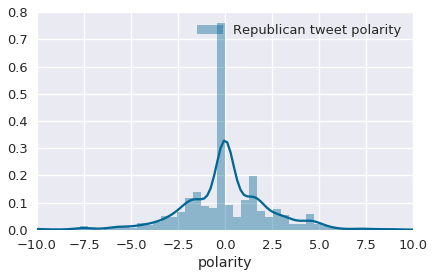

In [113]:
republican_tweets = cleaned_format[(cleaned_format['word'].str.contains('republican'))]
republican_pol = republican_tweets.merge(bot_tweets, right_index=True, left_index=True)['polarity']
sns.distplot(republican_pol, label = 'Republican tweet polarity', color='#016795')
plt.xlim([-10, 10])
plt.legend()


I wrote a general function for people to mess around with. Go wild!

mean polarity:
-0.964886363636


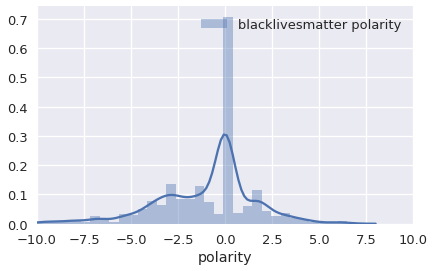

In [115]:
# see above for way more
# Check out whatever word you'd like!
def word_pol_search(word):
    word_tweets = cleaned_format[(cleaned_format['word'].str.contains(word))]
    word_pol = word_tweets.merge(bot_tweets, right_index=True, left_index=True)['polarity']
    sns.distplot(word_pol, label = word + ' polarity')
    plt.xlim([-10, 10])
    plt.legend()
    print('mean polarity:')
    print(word_pol.mean())
    
word_pol_search('blacklivesmatter')

### Discussion of Bot Results

Overall, we see that bot tweet polarity about controversial topics was as expected. Words such as Clinton, liberal, islam and immigrant tend to skew the graph negatively. However, the effect is not that pronounced, it seems. Over a large number of bots, it does converge slightly towards 0. Additionally, I noticed some of the tweeters take positions that are considered 'far left'. 

I am hoping to look at this data more deeply--currently this is a work in progress! For example, there were lots of tweets that get truncated due to twitter formating. Additionally, dealing with the large number of near-zero polarity tweets needs to be better (i.e. some of them are meaningless and should be thrown out). Also, vader analysis is not perfect (for example, it does not pick up on sarcasm e.g. 'religion of peace', or context). I discuss this in one of the earlier problems. 

I am curious to know how many people actually read and interacted with these 3000 bots. Hopefully more data gets released from the investigators as time goes on!

Overall, I still have lots of work to do with this data. There is lots to find out! Reach out to me if you have any ideas!